# Preparations

In [1]:
!pip install prophet
!pip install sktime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.9/36.9 MB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.5/141.5 kB 10.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sktime.performance_metrics.forecasting import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score

# XGBoost
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# ✅ Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

from prophet.make_holidays import make_holidays_df

Mounted at /content/drive


# Clusters

In [3]:
cluster_dfs = []
for year in range(2020,2024):
  cluster_df = pd.read_csv(f'/content/drive/Shared drives/Time Series/Notebooks/Modeling/modeling_andy/clusters/cluster_df_{year}_{5}clusters_100toplimit_complete.csv')
  cluster_dfs.append(cluster_df)
cluster_dfs[0].head()

,start_station_name,cluster
0,10101 S Stony Island Ave,0
1,111th St - Morgan Park Metra,0
2,2112 W Peterson Ave,0
3,351,0
4,410,0


In [4]:
# prompt: outer join all cluster df to examin cluster stability

import pandas as pd
# Assuming 'cluster_id' is the common column across all DataFrames
merged_df = cluster_dfs[0]
for i in range(1, len(cluster_dfs)):
  merged_df = pd.merge(merged_df, cluster_dfs[i], on='start_station_name', how='outer', suffixes=('', f'_{i+2020}'))

# Display or further process the merged DataFrame
cluster_df = merged_df.rename(columns={"cluster":"cluster_2020"})
cluster_df.head()

,start_station_name,cluster_2020,cluster_2021,cluster_2022,cluster_2023
0,10101 S Stony Island Ave,0,0,0,0
1,111th St - Morgan Park Metra,0,0,0,0
2,2112 W Peterson Ave,0,0,0,0
3,351,0,0,0,0
4,410,0,0,0,0


## Stability

### Cluster Size

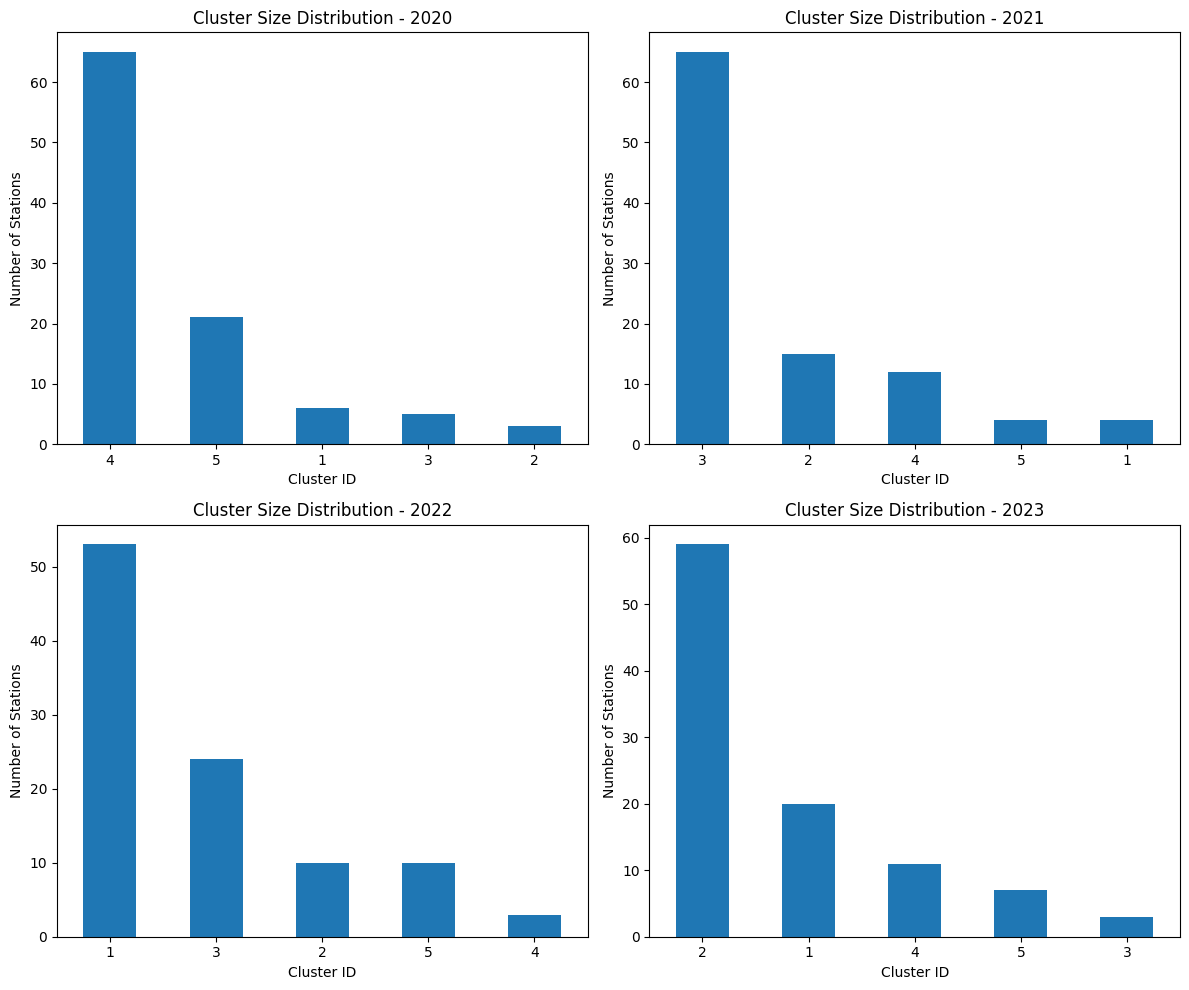

In [5]:
# prompt: visualize each year's cluster size distribution, exclude cluster 0, make the bar plot a 2x2 one, make sure the xticks is vertical

import matplotlib.pyplot as plt

# Assuming 'cluster_df' is your DataFrame and it has columns like 'cluster_2020', 'cluster_2021', etc.
# and 'start_station_name'

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for i, year in enumerate(range(2020, 2024)):
    cluster_col = f"cluster_{year}"
    if cluster_col in cluster_df.columns:
      cluster_counts = cluster_df[cluster_col].value_counts()
      cluster_counts = cluster_counts.drop(0, errors='ignore')  # Exclude cluster 0
      ax = axes[i]
      cluster_counts.plot(kind='bar', ax=ax)
      ax.set_title(f'Cluster Size Distribution - {year}')
      ax.set_xlabel('Cluster ID')
      ax.set_ylabel('Number of Stations')

      # Rotate x-axis labels vertically
      ax.tick_params(axis='x', rotation=0)
plt.tight_layout()
plt.show()


### Map Visualization

In [6]:
expanded_df = pd.read_csv("/content/drive/Shared drives/Time Series/divvy_data/archive/full expanded/divvy_data_expanded.csv")
expanded_df.head()

<ipython-input-6-b43c3f27bf20>:1: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  expanded_df = pd.read_csv("/content/drive/Shared drives/Time Series/divvy_data/archive/full expanded/divvy_data_expanded.csv")


,rideable_type,date,start_station_name,end_station_name,start_station_id,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,rides
0,classic_bike,2020-12-02,900 W Harrison St,Wolcott Ave & Polk St,13028,TA1309000064,41.874754,-87.649807,41.871262,-87.673688,member,1
1,classic_bike,2020-12-02,Aberdeen St & Jackson Blvd,Clinton St & Roosevelt Rd,13157,WL-008,41.877726,-87.654787,41.867118,-87.641088,member,1
2,classic_bike,2020-12-02,Albany Ave & Montrose Ave,Kedzie Ave & Milwaukee Ave,15621,13085,41.961041,-87.705866,41.929567,-87.707857,member,1
3,classic_bike,2020-12-02,Ashland Ave & 13th St,Blue Island Ave & 18th St,13354,13135,41.865234,-87.666507,41.857556,-87.661535,member,1
4,classic_bike,2020-12-02,Ashland Ave & Augusta Blvd,Ashland Ave & Augusta Blvd,13248,13248,41.899643,-87.667700,41.899643,-87.667700,casual,1


In [7]:
def plot_cluster_map(year, cluster_df, n_clusters=3):
    """
    Plots a folium map of bike share stations clustered by given year.

    Parameters:
    - year: int, the year for which clusters are plotted.
    - cluster_df: DataFrame, containing cluster assignments for stations.
    - n_clusters: int, number of clusters (between 2 and 5).

    Returns:
    - folium.Map object with clusters plotted.
    """
    # Ensure n_clusters is within the valid range
    n_clusters = max(2, min(n_clusters, 5))

    cluster_col = f"cluster_{year}"
    top_100 = cluster_df[cluster_df[cluster_col] != 0]["start_station_name"]

    coordinate_df = expanded_df.loc[
        expanded_df["start_station_name"].isin(top_100)
    ].groupby(["start_station_name", "start_lat", "start_lng"]).count().reset_index()

    avg_coord_df = coordinate_df.groupby("start_station_name").mean().reset_index()[["start_station_name", "start_lat", "start_lng"]]
    cluster_coord_df = avg_coord_df.merge(cluster_df, on="start_station_name", how="left")

    import pandas as pd
    import folium
    from folium.plugins import MarkerCluster

    # Map centered on Chicago
    chicago_coords = [41.8781, -87.6298]
    chicago_map = folium.Map(location=chicago_coords, zoom_start=12)

    # Define colors for clusters dynamically
    cluster_colors = {
        1: 'red',
        2: 'blue',
        3: 'green',
        4: 'purple',
        5: 'orange',
    }

    # Add markers for each station with color based on cluster
    for idx, row in cluster_coord_df.iterrows():
        cluster_id = row[cluster_col]
        color = cluster_colors.get(cluster_id, 'gray') if 1 <= cluster_id <= n_clusters else 'gray'

        folium.Marker(
            location=[row['start_lat'], row['start_lng']],
            popup=f"{row['start_station_name']} (Cluster: {cluster_id})",
            tooltip=row['start_station_name'],
            icon=folium.Icon(color=color)
        ).add_to(chicago_map)

    # Add a dynamic legend
    legend_html = '''
    <div style="position: fixed;
        bottom: 50px; right: 50px; width: 150px; height: auto;
        border:2px solid grey; z-index:9999; font-size:14px;
        background-color:white; padding: 10px;
        ">
        <b>Cluster Legend</b><br>
    '''
    for i in range(1, n_clusters + 1):
        legend_html += f'<i class="fa fa-map-marker fa-2x" style="color:{cluster_colors[i]};"></i> Cluster {i}<br>'

    legend_html += '</div>'
    chicago_map.get_root().html.add_child(folium.Element(legend_html))

    return chicago_map

# Example usage:
plot_cluster_map(2020, cluster_df, n_clusters=5)


In [8]:
plot_cluster_map(2021,cluster_df, n_clusters=5)

In [9]:
plot_cluster_map(2022,cluster_df, n_clusters=5)

In [10]:
plot_cluster_map(2023,cluster_df, n_clusters=5)